# CS4248 Fake News Detection
AY22/23 Semester 2 || Group 09  
Sequence Modeling - LSTM Experiments

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import sys
import json
import time
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import spacy
from typing import Union, Any
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
import torch.optim as optim
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

## Data Pre-processing

In [3]:
# General Parameters
DATA_DIR = "drive/My Drive/NLP/raw_data"
SAVE_DIR = "drive/My Drive/NLP" # Empty string if same as working dir

# Tunable Parameters
VOCAB_FREQ = 3
MAX_TOKENS = 100
BATCH_SIZE = 256

In [4]:
# Get working directories
curr_dir = os.getcwd()
data_dir = os.path.join(curr_dir, DATA_DIR)
save_dir = os.path.join(curr_dir, SAVE_DIR)

In [5]:
def convert_df_to_list(
    df: pd.DataFrame,
    label_col: str="class",
    text_col:  str="text"
) -> list:
    data = df[[label_col, text_col]]
    tuple_list = list(
        data.itertuples(index=False, name=None)
    )
    
    return tuple_list

# Parse train and test datasets
train_df = pd.read_csv(f"{data_dir}/fulltrain.csv",     header=None, names=["class","text"])
test_df  = pd.read_csv(f"{data_dir}/balancedtest.csv",  header=None, names=["class","text"])

# Convert train and test datasets to list
train_data = convert_df_to_list(train_df)
test_data  = convert_df_to_list(test_df)

In [6]:
# Build vocabulary
tokenizer = get_tokenizer(tokenizer="spacy", language="en_core_web_sm")
stopwords = spacy.lang.en.stop_words.STOP_WORDS

def yield_tokens(data: Union[list,iter]):
    for _, text in data:
        yield [
            token for token in tokenizer(text)
            if token not in stopwords and token.isalpha()
        ]

vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<UNK>"], min_freq=VOCAB_FREQ)
vocab.set_default_index(vocab["<UNK>"])
print(f"Vocab Size: {len(vocab)}")

Vocab Size: 105153


In [7]:
def generate_data_loader(
    data: list,
    vocab: Any,
    tokenizer: Any,
    stopwords: Any,
    train_valid_split: bool=False,
    max_tokens: Union[int,float]=100,
    batch_size: int=256,
    split_ratio: float=0.95
):
    def vectorize_function(
        batch: list, 
        vocab: Any,
        max_tokens: int
    ):
        Y, X = list(zip(*batch))
        X = [vocab([
            token for token in tokenizer(sentence) 
            if token not in stopwords and token.isalpha()
        ]) for sentence in X]
        X = [
            tokens + ([0]* (max_tokens - len(tokens))) if len(tokens) < max_tokens else 
            tokens[:max_tokens] for tokens in X
        ] 

        return torch.tensor(X, dtype=torch.int32), torch.tensor(Y) - 1

    dataset = to_map_style_dataset(data)

    if max_tokens < 1 or type(max_tokens) == float:
        # Set max tokens as fraction of total vocab size
        max_tokens = int(max_tokens * len(vocab))

    if train_valid_split:
        split_ratio = split_ratio if split_ratio < 1 else 0.95
        total_size = len(dataset)
        train_size = int(total_size * split_ratio)
        train_dataset, valid_dataset = D.random_split(
            dataset, [train_size, total_size - train_size]
        )

        return (
            D.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda b: vectorize_function(b, vocab, max_tokens)),
            D.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda b: vectorize_function(b, vocab, max_tokens))
        )
    else:
        return D.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda b: vectorize_function(b, vocab, max_tokens))

# Generate Data Loader
train_loader = generate_data_loader(
    train_data, vocab, tokenizer, stopwords, False, MAX_TOKENS, BATCH_SIZE
)
test_loader = generate_data_loader(
    test_data,  vocab, tokenizer, stopwords, False, MAX_TOKENS, BATCH_SIZE
)

## Model Architecture

In [8]:
# Fixed Parameters
MODEL_DIR = "model_single_lstm_V8"
NUM_CLASS = len(set([text[0] for text in train_data]))
VOCAB_SIZE = len(vocab)

# Tunable Parameters
EMBEDDING_SIZE = 256
HIDDEN_SIZE = 128
N_LAYERS = 1
DROPOUT_RATIO = 0.25

# Training Hyperparameters
EPOCH = 5
LR = 0.01
DECAY_STEP = 1
DECAY_RATE = 0.5

In [9]:
def view_model_params(model: nn.Module):
    for layer in model.children():
        print("Layer ::")
        print(f"   {layer}")
        print("Parameters ::")
        
        for param in layer.parameters():
            print(f"   {param.shape}")
        
        print("")

class SingleLSTMClassifier(nn.Module):
    def __init__(
        self, 
        num_class: int,
        vocab_size: int, 
        embedding_size: int=512,
        hidden_size: int=128,
        n_layers: int=1,
        dropout_ratio: float=0.20
    ):
        super(SingleLSTMClassifier, self).__init__()
        
        # Model parameters
        self.embedding_size = int(embedding_size) if (
            embedding_size is not None and embedding_size > 0
        ) else 256

        self.n_layers = int(n_layers) if (
            n_layers is not None and n_layers > 0
        ) else 1

        self.hidden_size = int(hidden_size) if (
            hidden_size is not None and hidden_size > 0
        ) else 128

        self.dropout_ratio = float(dropout_ratio) if (
            dropout_ratio is not None and dropout_ratio < 1
        ) else 0.20

        if self.n_layers > 1:
            self.lstm_dropout = dropout_ratio
        else:
            self.lstm_dropout = 0.0

        # Model layers
        self.dropout = nn.Dropout(dropout_ratio)
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, 
            embedding_dim=self.embedding_size
        )
        self.lstm = nn.LSTM(
            input_size=self.embedding_size, 
            hidden_size=self.hidden_size,
            num_layers=self.n_layers,
            dropout=self.lstm_dropout,
            batch_first=True
        )
        self.linear = nn.Linear(
            in_features=self.hidden_size, 
            out_features=num_class
        )

    def forward(self, X_batch):
        word_embeddings = self.embedding(X_batch)
        h = torch.randn(self.n_layers, len(X_batch), self.hidden_size)
        c = torch.randn(self.n_layers, len(X_batch), self.hidden_size)

        if torch.cuda.is_available():
            h = h.cuda()
            c = c.cuda()

        output, (h, c) = self.lstm(word_embeddings, (h, c))
        output = self.dropout(output)

        return self.linear(output[:,-1])

In [10]:
# Check if GPU present
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate model
single_lstm_classifier = SingleLSTMClassifier(
    NUM_CLASS, 
    VOCAB_SIZE, 
    EMBEDDING_SIZE, 
    HIDDEN_SIZE, 
    N_LAYERS,
    DROPOUT_RATIO
).to(device)

# View model architecture
view_model_params(single_lstm_classifier)

Layer ::
   Dropout(p=0.25, inplace=False)
Parameters ::

Layer ::
   Embedding(105153, 256)
Parameters ::
   torch.Size([105153, 256])

Layer ::
   LSTM(256, 128, batch_first=True)
Parameters ::
   torch.Size([512, 256])
   torch.Size([512, 128])
   torch.Size([512])
   torch.Size([512])

Layer ::
   Linear(in_features=128, out_features=4, bias=True)
Parameters ::
   torch.Size([4, 128])
   torch.Size([4])



## Model Training

In [11]:
# Save and Load Functions
def save_checkpoint(save_path, model, optimizer, valid_loss):
    if save_path == None:
        return
    
    state_dict = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "valid_loss": valid_loss
    }
    
    torch.save(state_dict, save_path)
    print(f"| Model saved  >> {save_path}")


def load_checkpoint(load_path, model, optimizer, device):
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f"| Model loaded  << {load_path}")
    
    model.load_state_dict(state_dict["model_state_dict"])
    optimizer.load_state_dict(state_dict["optimizer_state_dict"])
    
    return state_dict["valid_loss"]


def save_metrics(
    save_path, 
    epoch_list, step_list,
    train_loss_list, valid_loss_list, 
    valid_acc_list,  valid_f1_list
):
    if save_path == None:
        return
    
    state_dict = {
        "epoch_list": epoch_list,
        "step_list": step_list,
        "train_loss_list": train_loss_list,
        "valid_loss_list": valid_loss_list,
        "valid_acc_list":  valid_acc_list,
        "valid_f1_list":  valid_f1_list
    }
    
    torch.save(state_dict, save_path)
    print(f"| Model saved  >> {save_path}")


def load_metrics(load_path, device):
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f"| Model loaded << {load_path}")
    
    return (
        state_dict["epoch_list"],
        state_dict["step_list"],
        state_dict["train_loss_list"], 
        state_dict["valid_loss_list"], 
        state_dict["valid_acc_list"], 
        state_dict["valid_f1_list"]
    )        

In [12]:
# Train and evaluate functions
def evaluate(
    model,
    loader,
    criterion=nn.CrossEntropyLoss(),
    test: bool=False
):  
    valid_loss_list = []
    y_true_list, y_pred_list = [], [] 
    
    with torch.no_grad():
        for X, Y in loader:
            if torch.cuda.is_available():
                X = X.cuda()
                Y = Y.cuda()
                y_pred = model(X).cuda()   # Get model predictions
            else:
                y_pred = model(X)

            loss = criterion(y_pred, Y)  # Calculate loss

            # Save validation results
            valid_loss_list.append(loss.item())
            y_true_list.append(Y)
            y_pred_list.append(y_pred.argmax(dim=-1))

        avg_valid_loss = torch.tensor(valid_loss_list).mean()
        Y_true_all = torch.cat(y_true_list).detach()
        Y_pred_all = torch.cat(y_pred_list).detach()

        if torch.cuda.is_available():
            Y_true_all = Y_true_all.cpu().numpy()
            Y_pred_all = Y_pred_all.cpu().numpy()

    if not test:
        return (
            avg_valid_loss,
            accuracy_score(Y_true_all, Y_pred_all),
            f1_score(Y_true_all, Y_pred_all, average="weighted")
        )
    else:
        return (
            Y_true_all,
            Y_pred_all,
            accuracy_score(Y_true_all, Y_pred_all),
            f1_score(Y_true_all, Y_pred_all, average="weighted"),
            f1_score(Y_true_all, Y_pred_all, average="micro")
        )


def train(
    model,
    optimizer,
    train_loader,
    valid_loader,
    criterion=nn.CrossEntropyLoss(),
    scheduler=None,
    num_epochs=5,
    eval_interval=5,
    best_valid_loss=float("Inf"),
    best_valid_f1=0.25,
    save_path=f"{os.getcwd()}/model",
):
    # Initialise values
    train_loss = []

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    # Initialise results list
    epoch_list = []
    step_list = []
    train_loss_list = []
    valid_loss_list = []
    valid_acc_list = []
    valid_f1_list = []

    # Begin training loop
    for epoch in range(1, num_epochs+1):
        start_time = time.time()
        train_loss = []
        train_size = len(train_loader)
        model.train()

        for idx, (X, Y) in enumerate(train_loader, start=1):
            # Obtain predictions
            model.zero_grad()
            if torch.cuda.is_available():
                X = X.cuda()
                Y = Y.cuda()
                Y_train_pred = model(X).cuda()
            else:
                Y_train_pred = model(X)

            # Calculate and save loss
            loss = criterion(Y_train_pred, Y)
            train_loss.append(loss.item())

            # Update network weights by backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (idx % eval_interval == 0) or idx == 1:
                # Compute validation metrics
                model.eval()
                avg_valid_loss, valid_acc, valid_f1 = evaluate(
                    model, valid_loader, criterion
                )
                avg_train_loss = torch.tensor(train_loss).mean()
                train_loss = []
                model.train()

                print(
                    "| Epoch {:3d} | {:5d}/{:5d} Batches | Train Loss: {:8.3f} | Valid Loss: {:8.3f} | Valid Acc: {:8.3f} | Valid F1: {:8.3f}" .format(
                        epoch, idx, train_size, avg_train_loss, avg_valid_loss, valid_acc, valid_f1
                    )
                )

                # Save metrics
                epoch_list.append(epoch)
                step_list.append(idx)
                train_loss_list.append(avg_train_loss)
                valid_loss_list.append(avg_valid_loss)
                valid_acc_list.append(valid_acc)
                valid_f1_list.append(valid_f1)

                # Checkpoint
                if (best_valid_loss > avg_valid_loss) or (best_valid_f1 < valid_f1):
                    best_valid_loss = min(avg_valid_loss, best_valid_loss)
                    best_valid_f1 = max(valid_f1, best_valid_f1)

                    save_checkpoint(f"{save_path}/model.pt", model, optimizer, avg_valid_loss)
                    save_metrics(
                        f"{save_path}/metrics.pt", epoch_list, step_list,
                        train_loss_list, valid_loss_list, valid_acc_list, valid_f1_list
                    )
        
        if scheduler is not None:
            scheduler.step()
            
        print("-" * 60)
        print("| End of Epoch {:3d} | Time: {:5.2f}s".format(epoch, time.time()-start_time))
        print("-" * 60)

    print("Completed Model Training")

In [13]:
# Define training objects
criterion = torch.nn.CrossEntropyLoss()
single_lstm_optimizer = optim.Adam(single_lstm_classifier.parameters(), lr=LR)
single_lstm_scheduler = optim.lr_scheduler.StepLR(single_lstm_optimizer, step_size=DECAY_STEP, gamma=DECAY_RATE)

In [ ]:
# Execute model training
train(
    single_lstm_classifier,
    single_lstm_optimizer,
    train_loader,
    test_loader,
    criterion=criterion,
    scheduler=single_lstm_scheduler,
    num_epochs=EPOCH,
    save_path=f"{save_dir}/{MODEL_DIR}"
)

| Epoch   1 |     1/  191 Batches | Train Loss:    1.415 | Valid Loss:    1.439 | Valid Acc:    0.303 | Valid F1:    0.258
| Model saved  >> /content/drive/My Drive/NLP/model_single_lstm_V8/model.pt
| Model saved  >> /content/drive/My Drive/NLP/model_single_lstm_V8/metrics.pt
| Epoch   1 |     5/  191 Batches | Train Loss:    1.347 | Valid Loss:    1.439 | Valid Acc:    0.333 | Valid F1:    0.232
| Epoch   1 |    10/  191 Batches | Train Loss:    1.283 | Valid Loss:    1.471 | Valid Acc:    0.344 | Valid F1:    0.256
| Epoch   1 |    15/  191 Batches | Train Loss:    1.265 | Valid Loss:    1.404 | Valid Acc:    0.357 | Valid F1:    0.289
| Model saved  >> /content/drive/My Drive/NLP/model_single_lstm_V8/model.pt
| Model saved  >> /content/drive/My Drive/NLP/model_single_lstm_V8/metrics.pt
| Epoch   1 |    20/  191 Batches | Train Loss:    1.217 | Valid Loss:    1.455 | Valid Acc:    0.395 | Valid F1:    0.334
| Model saved  >> /content/drive/My Drive/NLP/model_single_lstm_V8/model.pt
|

In [14]:
# Load saved model
model = single_lstm_classifier
load_checkpoint(
    f"{save_dir}/{MODEL_DIR}/model.pt", 
    model, 
    single_lstm_optimizer, 
    device
)

# Evaluate model
y_true, y_pred, accuracy_score, f1_weighted, f1_micro = evaluate(
    model, test_loader, criterion, test=True
)
print(f"Test Accuracy: {accuracy_score}")
print(f"Test F1 (Weighted): {f1_weighted}")
print(f"Test F1 (Micro): {f1_micro}")

| Model loaded  << /content/drive/My Drive/NLP/model_single_lstm_V8/model.pt
Test Accuracy: 0.6683333333333333
Test F1 (Weighted): 0.6656283017082685
Test F1 (Micro): 0.6683333333333333


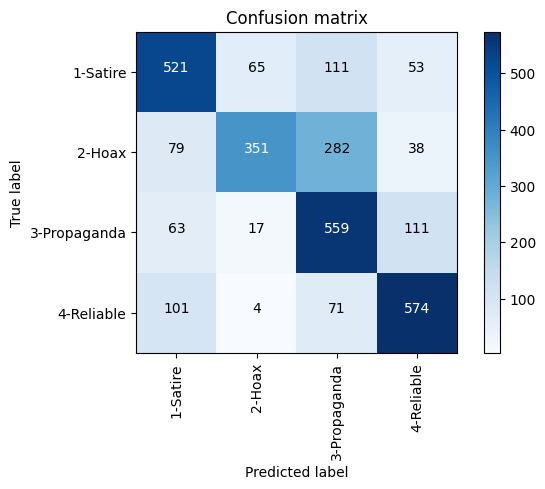

In [15]:
# Visualise confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

confusion_mtx = confusion_matrix(y_true, y_pred)
classes = ['1-Satire','2-Hoax','3-Propaganda','4-Reliable']
plot_confusion_matrix(confusion_mtx, classes)